# Milestone 3

In [1]:
# Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

In [2]:
# Display options
pd.set_option('display.max_rows', 100)

In [3]:
# Read CSV data
voter_blocks_all = pd.read_csv('../data/MA_l2_2022stats_2020block/MA_l2_2022stats_2020block.csv', low_memory=False).set_index('geoid20')
display(voter_blocks_all.shape)

# Read shapefile
block_groups_all = gpd.read_file('../data/ma_pl2020_bg/ma_pl2020_bg.shp')
display(block_groups_all.shape)


(107292, 395)

(5116, 346)

In [4]:
# Group demographic columns together
registered = ['total_reg']
age = ['age_18_19', 'age_20_24', 'age_25_29','age_30_34','age_35_44', 'age_45_54', 'age_55_64', 'age_65_74','age_75_84', 'age_85over']
gender = [ 'voters_gender_m', 'voters_gender_f', 'voters_gender_unknown'] 
party = ['party_npp', 'party_dem', 'party_rep','party_lib', 'party_grn', 'party_con', 'party_ain', 'party_scl','party_oth', 'party_unk']
ethnicity1 = ['eth1_eur', 'eth1_hisp', 'eth1_aa',
                'eth1_esa', 'eth1_oth', 'eth1_unk']
ethnicity2 = ['eth2_euro', 'eth2_64',
                'eth2_93', 'eth2_10', 'eth2_30', 'eth2_23', 'eth2_66', 'eth2_34',
                'eth2_21', 'eth2_35', 'eth2_14', 'eth2_12', 'eth2_55', 'eth2_13',
                'eth2_32', 'eth2_61', 'eth2_85', 'eth2_29', 'eth2_33', 'eth2_38',
                'eth2_15', 'eth2_57', 'eth2_19', 'eth2_26', 'eth2_59', 'eth2_unk']
languages = ['languages_description_english', 'languages_description_spanish',
                'languages_description_portuguese',
                'languages_description_chinese', 'languages_description_italian',
                'languages_description_vietnamese', 'languages_description_other',
                'languages_description_unknown']
income = ['commercialdata_estimatedhhincomeamount_avg']


# Group variables related to the 2020 presidential election
presidential_2020 = ['g20201103_voted_all', 'g20201103_reg_all', 'g20201103_pct_voted_all',
                    'g20201103_voted_gender_m', 'g20201103_reg_gender_m',
                    'g20201103_pct_voted_gender_m', 'g20201103_voted_gender_f',
                    'g20201103_reg_gender_f', 'g20201103_pct_voted_gender_f',
                    'g20201103_voted_gender_unk', 'g20201103_reg_gender_unk',
                    'g20201103_pct_voted_gender_unk', 'g20201103_voted_eur',
                    'g20201103_reg_eur', 'g20201103_pct_voted_eur', 'g20201103_voted_hisp',
                    'g20201103_reg_hisp', 'g20201103_pct_voted_hisp', 'g20201103_voted_aa',
                    'g20201103_reg_aa', 'g20201103_pct_voted_aa', 'g20201103_voted_esa',
                    'g20201103_reg_esa', 'g20201103_pct_voted_esa', 'g20201103_voted_oth',
                    'g20201103_reg_oth', 'g20201103_pct_voted_oth', 'g20201103_voted_unk',
                    'g20201103_reg_unk', 'g20201103_pct_voted_unk']

## Data Cleaning and Processing

### Missing Data Handling

#### 'NO BLOCK ASSIGNMENT' entries

We are choosing to ignore and drop these values because of inappropriate assumptions that need to be made if trying to disaggregate these entries.

Similarly, using counties as our unit of observation is difficult due to there only being 14 counties.

It seems as though counties with lower population have higher proportion of unassigned voters.

We will also explore the excluded data to determine which population groups we might be disproportionately excluding.

In [5]:
# Drop 'NO BLOCK ASSIGNMENT' entries
voter_blocks = voter_blocks_all[~voter_blocks_all.index.str.contains('NO BLOCK ASSIGNMENT')].copy()

#### Null voter turnout percentages

Some Census Block Groups have missing percentage voter turnout for the 2020 presidential election due to not having any voters registered for that election.

We choose to drop Census Block Groups that have zero voters registered for the 2020 presidential election (and total voters registered), as they are useless for our analysis.

In [6]:
# Drop Census Blocks with zero voters registered during the 2020 presidential election or ever
voter_blocks = voter_blocks[voter_blocks['g20201103_reg_all'] > 0]
voter_blocks = voter_blocks[voter_blocks['total_reg'] > 0]

###  Aggregation to Block Groups

Some Census Blocks are incredibly small, causing proportions to change wildly for small changes in counts.

We will aggregate the data to Census Block Groups to minimize the effects of incredibly small samples in Census Blocks.

#### Impute income data 

We are aggregating our data to the Census Block Group level and taking the mean of the mean household income at the Census Block level weighted by the number of total voters in each Census Block.

Even after imputation, there are 4 Census Block Groups still missing income data, with 14 voters in those Census Block Groups (0.00031% of the total).

We chose to drop these observations

In [7]:
# Weighted mean function based on total registered voters
wm = lambda x: (
    np.average(x.dropna(), weights=voter_blocks.loc[x.dropna().index, 'total_reg'])
    if voter_blocks.loc[x.dropna().index, 'total_reg'].sum() > 0
    else np.nan
)

# Define columns with counts for voters registered and voted in 2020 presidential election
presidential_counts = [col for col in presidential_2020 if not '_pct_' in col]

# Define aggregation method for columns
agg_funcs = {col: 'sum' for col in [*registered, *age, *gender, *party, *ethnicity1, *languages, *presidential_counts]}
agg_funcs.update({'commercialdata_estimatedhhincomeamount_avg': wm})

# Define block group ID
voter_blocks['block_group_id'] = voter_blocks.index.str[:12]
block_groups = voter_blocks.groupby('block_group_id').agg(agg_funcs)

# Rename the income column
block_groups = block_groups.rename({'commercialdata_estimatedhhincomeamount_avg':'mean_hh_income'}, axis=1)

In [8]:
block_groups[block_groups['mean_hh_income'].isna()]

,total_reg,age_18_19,age_20_24,age_25_29,age_30_34,age_35_44,age_45_54,age_55_64,age_65_74,age_75_84,...,g20201103_reg_hisp,g20201103_voted_aa,g20201103_reg_aa,g20201103_voted_esa,g20201103_reg_esa,g20201103_voted_oth,g20201103_reg_oth,g20201103_voted_unk,g20201103_reg_unk,mean_hh_income
block_group_id,,,,,,,,,,,,,,,,,,,,,
250173840031,9,0,0,1,1,3,1,2,1,0,...,2,0,0,0,0,0,1,0,1,NaN
250250612021,2,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
250259809001,2,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,NaN
250259815021,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN


In [9]:
print(f'After imputation, there are a total of {len(block_groups[block_groups['mean_hh_income'].isna()].index)} Census Block Groups still missing income data, with {block_groups[block_groups['mean_hh_income'].isna()]['total_reg'].sum()} voters in those Census Block Groups ({block_groups[block_groups['mean_hh_income'].isna()]['total_reg'].sum()/block_groups['total_reg'].sum():.5%} of the total).')

After imputation, there are a total of 4 Census Block Groups still missing income data, with 14 voters in those Census Block Groups (0.00031% of the total).


In [10]:
# Choose to drop NaN values for income due to low number of voters in these blocks.
block_groups = block_groups.dropna(subset='mean_hh_income')

#### Only keep columns of interest

We drop all other columns that are not of interest.

In [11]:
# Only keep columns of interest
predictors = [*registered, *age, *gender, *party, *ethnicity1, *languages, 'mean_hh_income']
# Other potential response variables could be g20201103_voted_all or those who voted and are a part of a certain demographic group
response = 'g20201103_pct_voted_all'
block_groups[response] = block_groups['g20201103_voted_all'] / block_groups['g20201103_reg_all']

### Take Proportions

Instead of using demographic counts as our predictors, we are choosing to use demographic proportions (i.e. the percentage of people that identify as _ in each Census Block Group).

We will use the number of voters registered in each Census Block Group as weights in our analysis to account for the fact that Census Block Groups with low voter registration counts can have wildly different demographic proportions.

In [12]:
def plot_vars(df):
    sns.histplot(df, x='total_reg')
    plt.show()

    sns.histplot(df, x='mean_hh_income')
    plt.show()

    sns.histplot(df, x=response)
    plt.show()

    sns.boxplot(df.melt(value_vars=age,var_name='Age Group',value_name='Count'),x='Age Group', y='Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    sns.boxplot(df.melt(value_vars=gender,var_name='Gender',value_name='Count'), x='Gender', y='Count')
    plt.show()

    sns.boxplot(df.melt(value_vars=party,var_name='Party',value_name='Count'), x='Party', y='Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    sns.boxplot(df.melt(value_vars=ethnicity1,var_name='Ethnicity',value_name='Count'), x='Ethnicity', y='Count')
    plt.show()

    sns.boxplot(df.melt(value_vars=languages,var_name='Language',value_name='Count'), x='Language', y='Count')
    plt.xticks(ticks=np.arange(len(languages)),labels=[lang[len('languages_description_'):] for lang in languages], rotation=45, ha='right')
    plt.show()

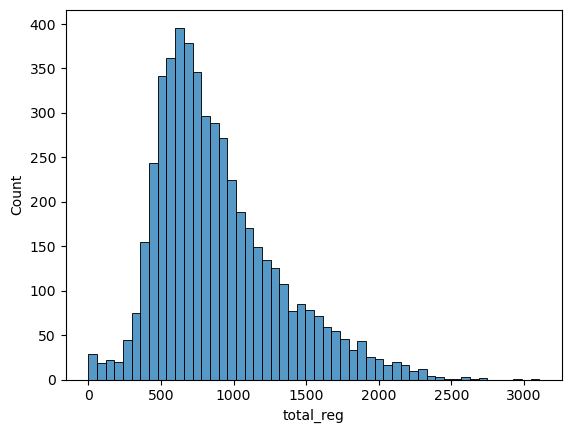

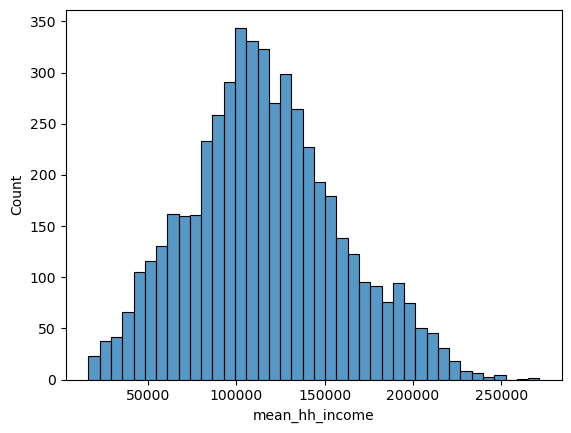

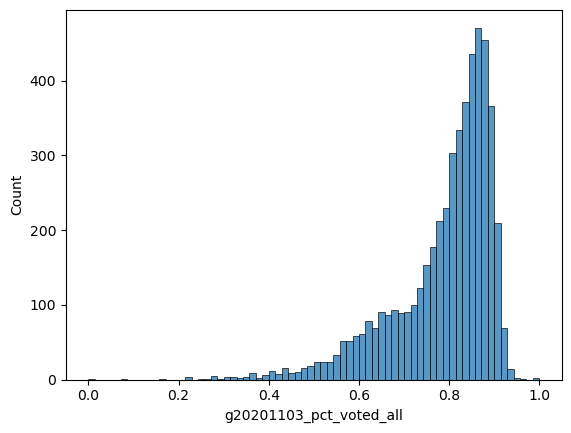

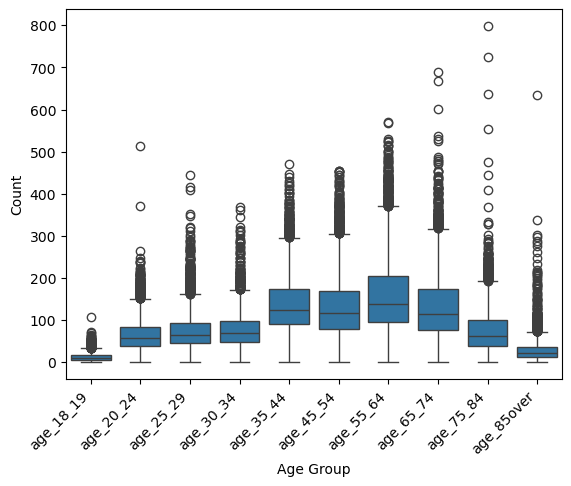

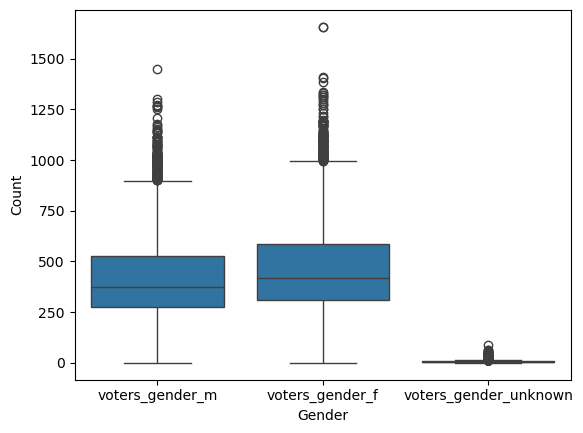

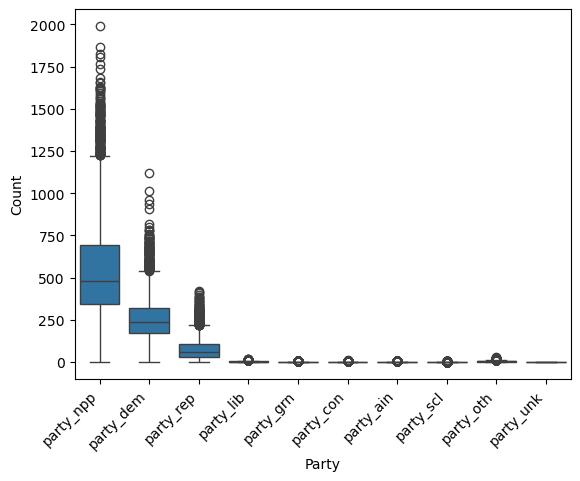

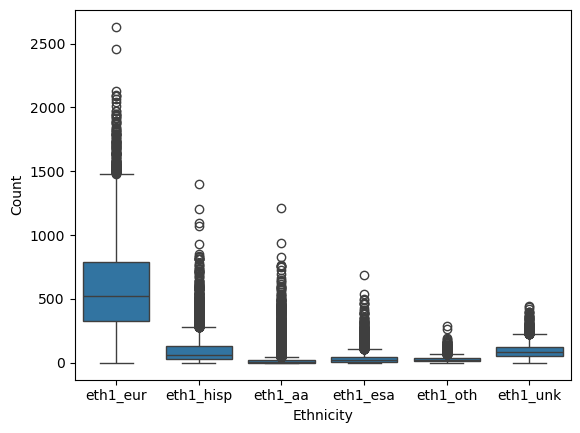

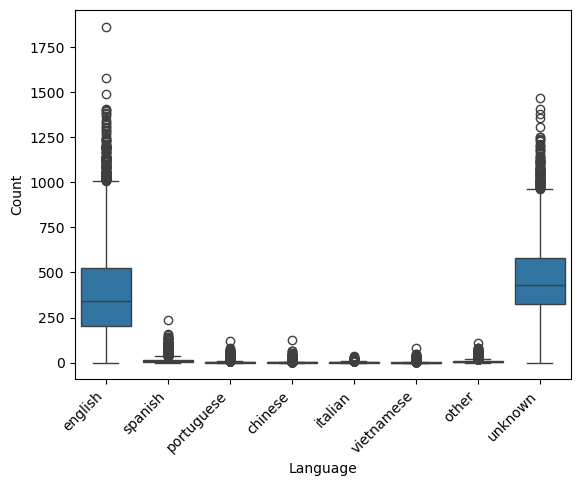

In [13]:
# Before transformation
plot_vars(block_groups)

In [14]:
# Take proportions
for cat in [*age, *gender, *party, *ethnicity1, *languages]:
    block_groups[cat] = block_groups[cat] / block_groups['total_reg']

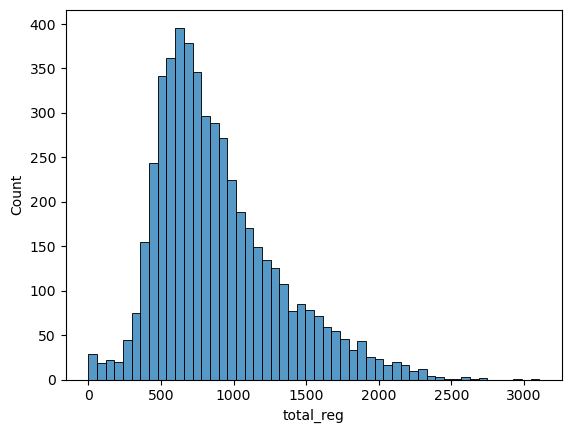

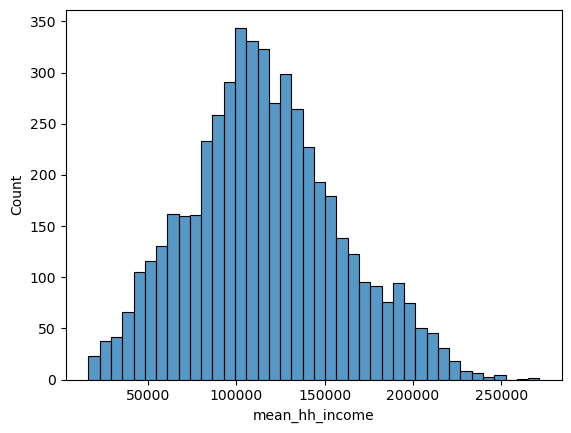

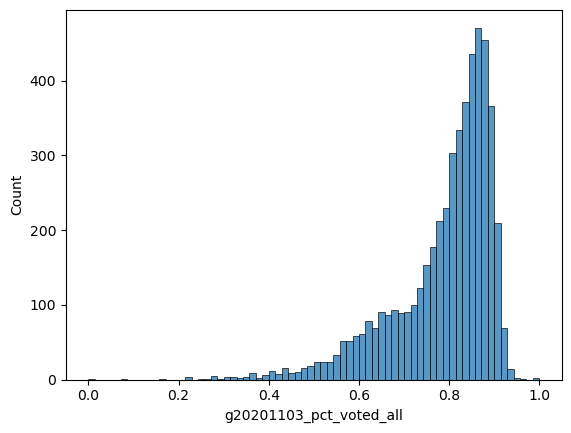

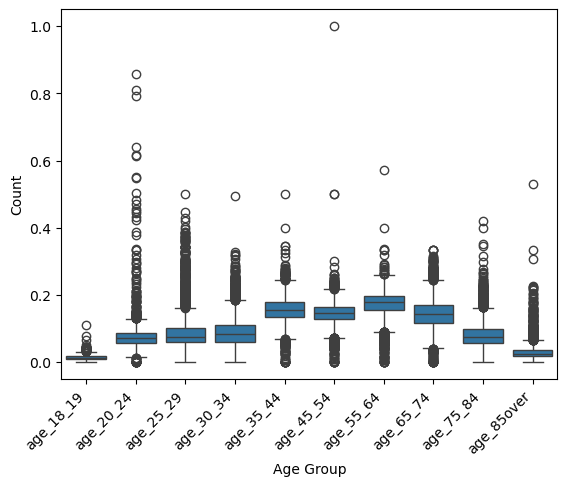

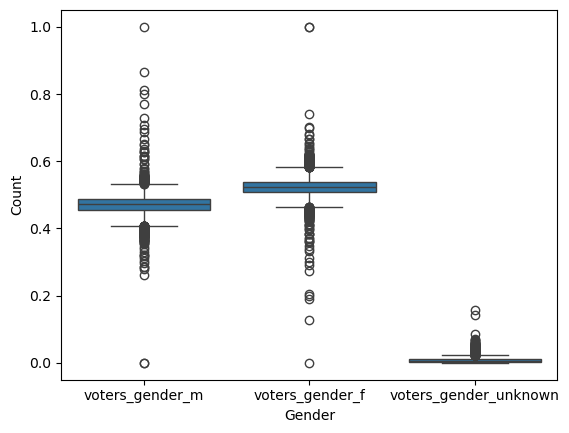

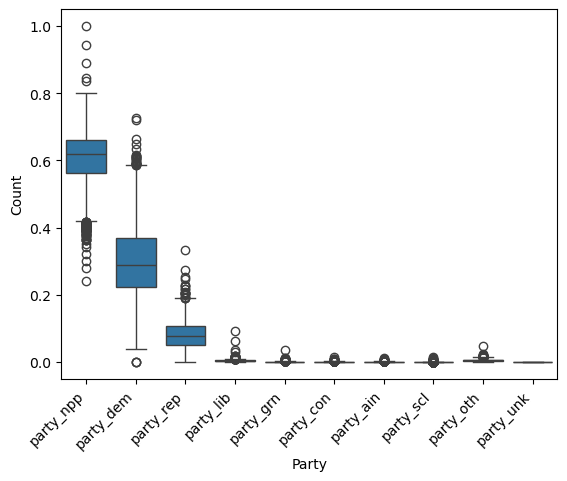

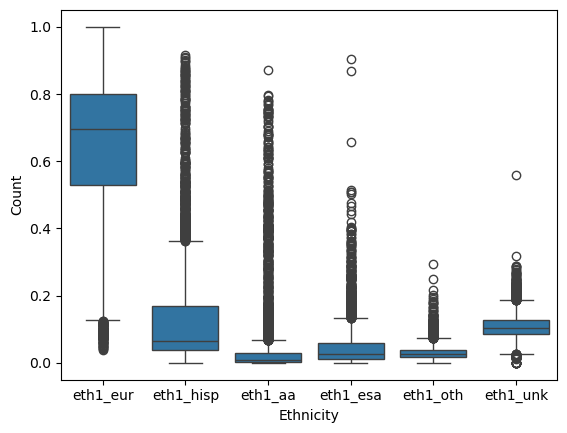

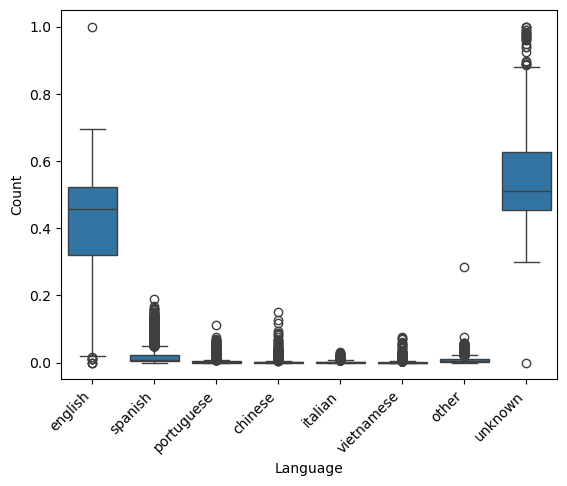

In [15]:
# After transformation
plot_vars(block_groups)

### Join to Shapefile

Finally, we join the data to Census Block Groups shapefile for visualization purposes and to potentially use the geographic locations of Census Blocks in our analysis.

In [16]:
final_gdf = block_groups_all.merge(block_groups, left_on='GEOID20', right_on='block_group_id').set_index('GEOID20').rename({'P0010001':'total_pop','P0030001':'18+_pop'}, axis=1)

# Total Non-Hispanic White population
final_gdf['total_nh_white'] = final_gdf['P0020005'] / final_gdf['total_pop']

# 18+ Non-Hispanic White population
final_gdf['18+_nh_white'] = final_gdf['P0040005'] / final_gdf['18+_pop']

# Total Hispanic population
final_gdf['total_hisp'] = final_gdf['P0020002'] / final_gdf['total_pop']

# 18+ Hispanic population
final_gdf['18+_hisp'] = final_gdf['P0040002'] / final_gdf['18+_pop']

# Total Any Part Black population (sum of Black alone and combinations)
final_gdf['total_ap_black'] = (
    final_gdf['P0020006'] +  # Black alone
    final_gdf['P0020013'] +  # White; Black or African American
    final_gdf['P0020018'] +  # Black or African American; American Indian and Alaska Native
    final_gdf['P0020019'] +  # Black or African American; Asian
    final_gdf['P0020020'] +  # Black or African American; Native Hawaiian and Other Pacific Islander
    final_gdf['P0020021']    # Black or African American; Some Other Race
)  / final_gdf['total_pop']

# 18+ Any Part Black population (sum of Black alone and combinations, 18+)
final_gdf['18+_ap_black'] = (
    final_gdf['P0040006'] +  # Black alone 18+
    final_gdf['P0040013'] +  # White; Black or African American 18+
    final_gdf['P0040018'] +  # Black or African American; American Indian and Alaska Native 18+
    final_gdf['P0040019'] +  # Black or African American; Asian 18+
    final_gdf['P0040020'] +  # Black or African American; Native Hawaiian and Other Pacific Islander 18+
    final_gdf['P0040021']    # Black or African American; Some Other Race 18+
) / final_gdf['18+_pop']

# Total Any Part Asian population (sum of Asian alone and combinations)
final_gdf['total_ap_asian'] = (
    final_gdf['P0020008'] +  # Asian alone
    final_gdf['P0020015'] +  # White; Asian
    final_gdf['P0020019'] +  # Black or African American; Asian
    final_gdf['P0020022'] +  # American Indian and Alaska Native; Asian
    final_gdf['P0020025'] +  # Asian; Native Hawaiian and Other Pacific Islander
    final_gdf['P0020026']    # Asian; Some Other Race
) / final_gdf['total_pop']

# 18+ Any Part Asian population (sum of Asian alone and combinations, 18+)
final_gdf['18+_ap_asian'] = (
    final_gdf['P0040008'] +  # Asian alone 18+
    final_gdf['P0040015'] +  # White; Asian 18+
    final_gdf['P0040019'] +  # Black or African American; Asian 18+
    final_gdf['P0040022'] +  # American Indian and Alaska Native; Asian 18+
    final_gdf['P0040025'] +  # Asian; Native Hawaiian and Other Pacific Islander 18+
    final_gdf['P0040026']    # Asian; Some Other Race 18+
) / final_gdf['18+_pop']

final_gdf['tract_id'] = final_gdf.index.str[:10]
final_gdf['county_id'] = final_gdf.index.str[:5]

In [17]:
# keep_cols = predictors + [response] + [presidential_counts] + ['tract_id','county_id','ALAND20', 'AWATER20', 'geometry', 'total_pop', '18+_pop', 'total_nh_white', '18+_nh_white', 'total_hisp', '18+_hisp', 'total_ap_black', '18+_ap_black', 'total_ap_asian', '18+_ap_asian']
keep_cols = predictors + [response] + presidential_counts + ['tract_id','county_id','ALAND20', 'AWATER20', 'geometry']
final_gdf = final_gdf[keep_cols]

### Final Data

After all processing has been done:
The number of voters registered has dropped from **4,606,321** to **4,532,271**.
**1.61%** of total registered voters were dropped.

In [18]:
print('\t\t\tBefore processing\tAfter processing')
print(f'Voters Registered:\t{voter_blocks_all['total_reg'].sum():,d}\t\t{final_gdf['total_reg'].sum():,d}')
print(f'{(voter_blocks_all['total_reg'].sum() - final_gdf['total_reg'].sum()) / voter_blocks_all['total_reg'].sum():.2%} of total registered voters were dropped.')

			Before processing	After processing
Voters Registered:	4,606,321		4,532,271
1.61% of total registered voters were dropped.


## Exploratory Data Analysis

### Summary of the Data

In [19]:
# Use final_gdf for further analysis
final_gdf.head()

,total_reg,age_18_19,age_20_24,age_25_29,age_30_34,age_35_44,age_45_54,age_55_64,age_65_74,age_75_84,...,g20201103_reg_esa,g20201103_voted_oth,g20201103_reg_oth,g20201103_voted_unk,g20201103_reg_unk,tract_id,county_id,ALAND20,AWATER20,geometry
GEOID20,,,,,,,,,,,,,,,,,,,,,
250010121011,1248,0.015224,0.054487,0.064904,0.060897,0.137019,0.153846,0.179487,0.172276,0.131410,...,12,20,25,85,111,2500101210,25001,5386342,146410,"POLYGON ((-70.25773 41.68514, -70.25759 41.685..."
250010121015,833,0.012005,0.046819,0.052821,0.070828,0.157263,0.126050,0.183673,0.189676,0.124850,...,5,21,25,56,75,2500101210,25001,1337254,128570,"POLYGON ((-70.24494 41.66438, -70.24453 41.664..."
250010121013,720,0.005556,0.047222,0.059722,0.062500,0.143056,0.118056,0.206944,0.195833,0.123611,...,4,10,11,32,45,2500101210,25001,1213246,219748,"POLYGON ((-70.22744 41.66549, -70.22728 41.665..."
250010121014,534,0.001873,0.056180,0.065543,0.132959,0.183521,0.134831,0.189139,0.127341,0.076779,...,1,4,8,32,50,2500101210,25001,1727377,152904,"POLYGON ((-70.2332 41.65252, -70.23319 41.6536..."
250277552022,774,0.018088,0.086563,0.043928,0.043928,0.134367,0.174419,0.195090,0.153747,0.113695,...,6,8,8,82,92,2502775520,25027,11073943,715639,"POLYGON ((-71.96833 42.0661, -71.96831 42.0662..."


In [20]:
final_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5078 entries, 250010121011 to 250250705022
Data columns (total 65 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   total_reg                         5078 non-null   int64   
 1   age_18_19                         5078 non-null   float64 
 2   age_20_24                         5078 non-null   float64 
 3   age_25_29                         5078 non-null   float64 
 4   age_30_34                         5078 non-null   float64 
 5   age_35_44                         5078 non-null   float64 
 6   age_45_54                         5078 non-null   float64 
 7   age_55_64                         5078 non-null   float64 
 8   age_65_74                         5078 non-null   float64 
 9   age_75_84                         5078 non-null   float64 
 10  age_85over                        5078 non-null   float64 
 11  voters_gender_m                   

In [21]:
final_gdf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_reg,5078.0,8.925307e+02,4.254450e+02,1.000000,591.000000,799.000000,1.108000e+03,3.106000e+03
age_18_19,5078.0,1.417500e-02,7.470527e-03,0.000000,0.009346,0.013725,1.840579e-02,1.111111e-01
age_20_24,5078.0,7.492519e-02,3.995227e-02,0.000000,0.057401,0.070690,8.645519e-02,8.571429e-01
age_25_29,5078.0,8.897739e-02,5.169338e-02,0.000000,0.059466,0.074322,1.006749e-01,5.000000e-01
age_30_34,5078.0,9.082774e-02,4.341842e-02,0.000000,0.060819,0.083199,1.103565e-01,4.961440e-01
age_35_44,5078.0,1.561007e-01,3.742002e-02,0.000000,0.134508,0.156757,1.784374e-01,5.000000e-01
age_45_54,5078.0,1.453437e-01,3.601458e-02,0.000000,0.127694,0.147612,1.640959e-01,1.000000e+00
age_55_64,5078.0,1.723604e-01,3.806182e-02,0.000000,0.154124,0.177751,1.964707e-01,5.714286e-01
age_65_74,5078.0,1.445612e-01,4.494739e-02,0.000000,0.117560,0.143099,1.688312e-01,3.351955e-01
age_75_84,5078.0,8.122930e-02,3.832612e-02,0.000000,0.055987,0.075758,9.871971e-02,4.189944e-01


### Scatterplots for Correlation Analysis

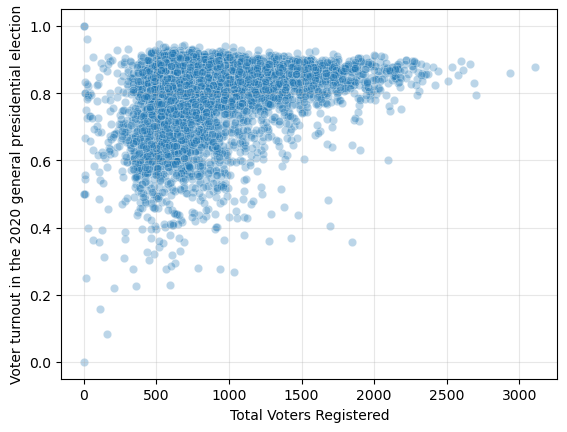

In [22]:
sns.scatterplot(final_gdf, x='total_reg', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Total Voters Registered')
plt.ylabel('Voter turnout in the 2020 general presidential election')
plt.grid(alpha=0.3)
plt.show()

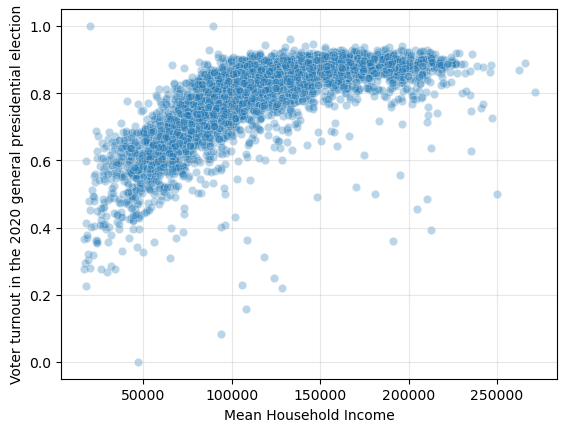

In [23]:
sns.scatterplot(final_gdf, x='mean_hh_income', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Mean Household Income')
plt.ylabel('Voter turnout in the 2020 general presidential election')
plt.grid(alpha=0.3)
plt.show()

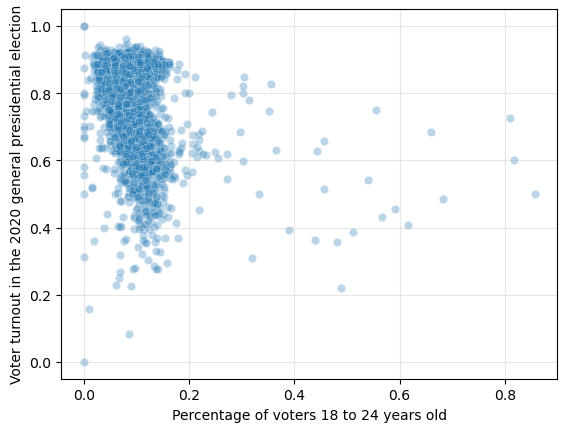

In [24]:
sns.scatterplot(x=final_gdf['age_18_19'] + final_gdf['age_20_24'], y=final_gdf['g20201103_pct_voted_all'], alpha=0.3)
plt.xlabel('Percentage of voters 18 to 24 years old')
plt.ylabel('Voter turnout in the 2020 general presidential election')
plt.grid(alpha=0.3)
plt.show()

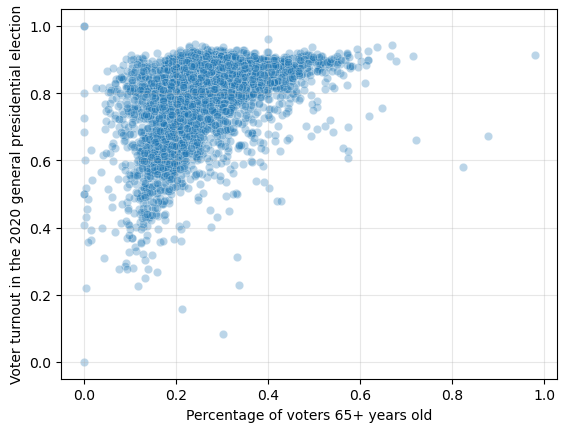

In [25]:
sns.scatterplot(x=final_gdf['age_65_74'] + final_gdf['age_75_84'] + final_gdf['age_85over'], y=final_gdf['g20201103_pct_voted_all'], alpha=0.3)
plt.xlabel('Percentage of voters 65+ years old')
plt.ylabel('Voter turnout in the 2020 general presidential election')
plt.grid(alpha=0.3)
plt.show()

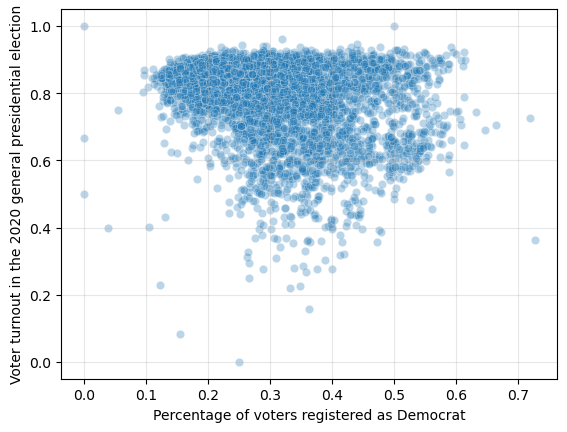

In [26]:
sns.scatterplot(final_gdf, x='party_dem', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters registered as Democrat')
plt.ylabel('Voter turnout in the 2020 general presidential election')
plt.grid(alpha=0.3)
plt.show()

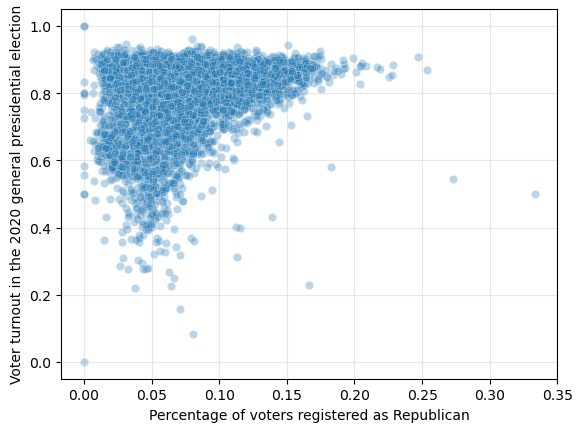

In [27]:
sns.scatterplot(final_gdf, x='party_rep', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters registered as Republican')
plt.ylabel('Voter turnout in the 2020 general presidential election')
plt.grid(alpha=0.3)
plt.show()

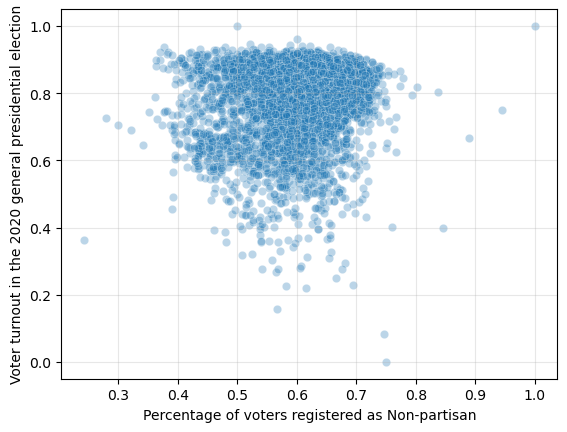

In [28]:
sns.scatterplot(final_gdf, x='party_npp', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters registered as Non-partisan')
plt.ylabel('Voter turnout in the 2020 general presidential election')
plt.grid(alpha=0.3)
plt.show()

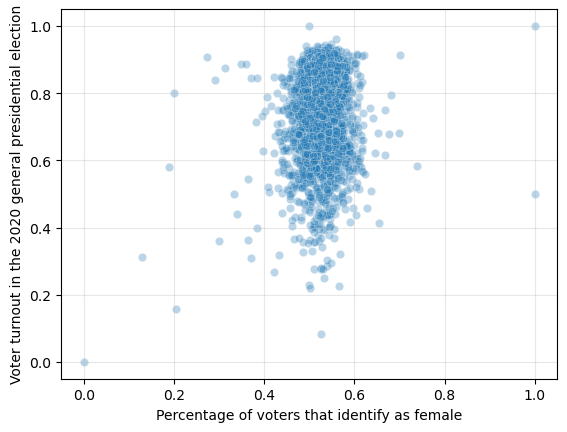

In [29]:
sns.scatterplot(final_gdf, x='voters_gender_f', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters that identify as female')
plt.ylabel('Voter turnout in the 2020 general presidential election')
plt.grid(alpha=0.3)
plt.show()

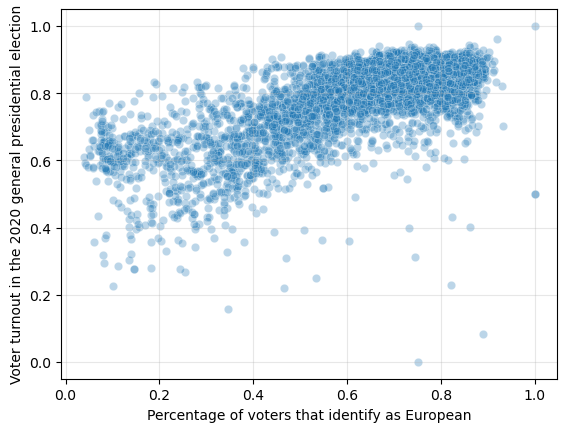

In [30]:
sns.scatterplot(final_gdf, x='eth1_eur', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters that identify as European')
plt.ylabel('Voter turnout in the 2020 general presidential election')
plt.grid(alpha=0.3)
plt.show()

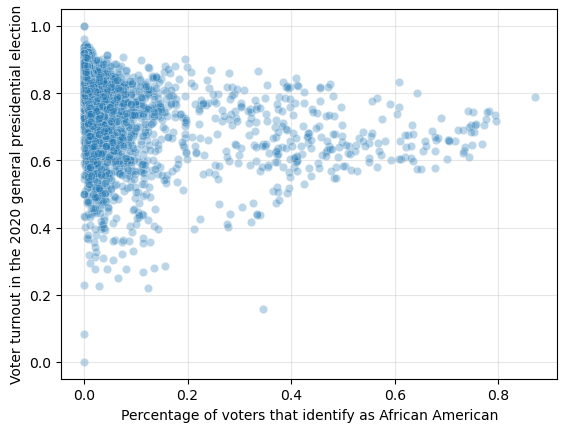

In [31]:
sns.scatterplot(final_gdf, x='eth1_aa', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters that identify as African American')
plt.ylabel('Voter turnout in the 2020 general presidential election')
plt.grid(alpha=0.3)
plt.show()

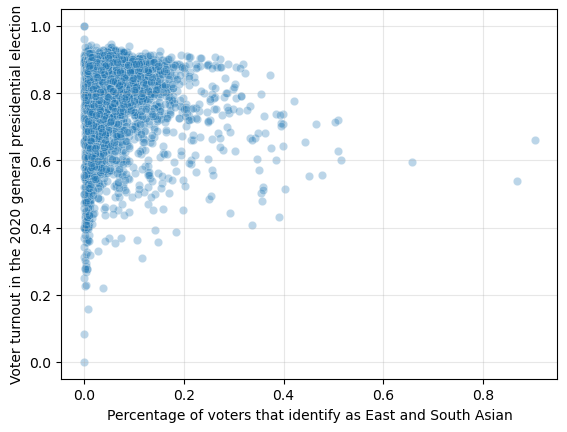

In [32]:
sns.scatterplot(final_gdf, x='eth1_esa', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters that identify as East and South Asian')
plt.ylabel('Voter turnout in the 2020 general presidential election')
plt.grid(alpha=0.3)
plt.show()

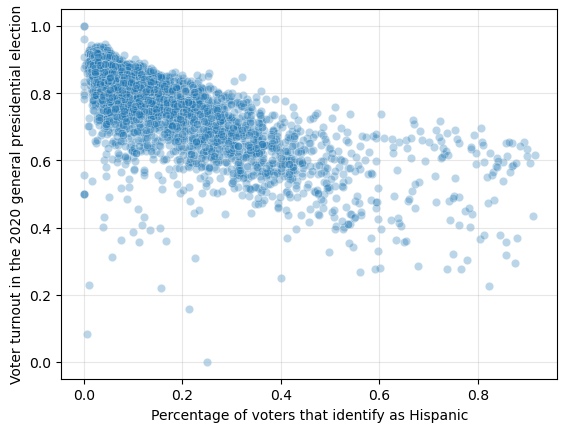

In [33]:
sns.scatterplot(final_gdf, x='eth1_hisp', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters that identify as Hispanic')
plt.ylabel('Voter turnout in the 2020 general presidential election')
plt.grid(alpha=0.3)
plt.show()

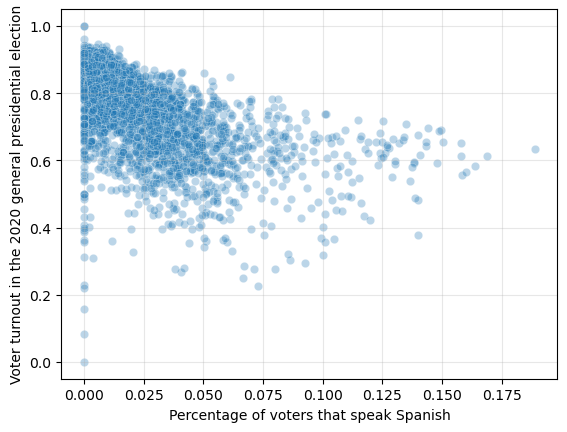

In [34]:
sns.scatterplot(final_gdf, x='languages_description_spanish', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters that speak Spanish')
plt.ylabel('Voter turnout in the 2020 general presidential election')
plt.grid(alpha=0.3)
plt.show()

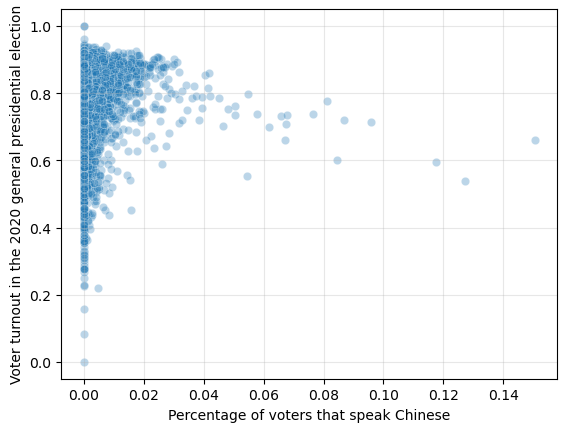

In [35]:
sns.scatterplot(final_gdf, x='languages_description_chinese', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters that speak Chinese')
plt.ylabel('Voter turnout in the 2020 general presidential election')
plt.grid(alpha=0.3)
plt.show()

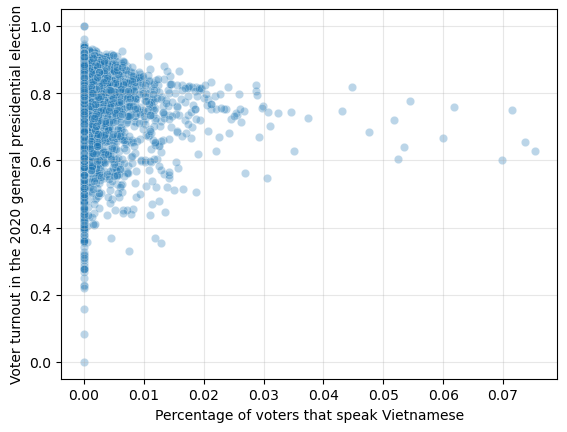

In [36]:
sns.scatterplot(final_gdf, x='languages_description_vietnamese', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters that speak Vietnamese')
plt.ylabel('Voter turnout in the 2020 general presidential election')
plt.grid(alpha=0.3)
plt.show()

### Map Visualizations

In [37]:
# Define tract and county GeoDataFrame
tract_gdf = final_gdf.dissolve(by='tract_id', aggfunc='sum')
tract_gdf['g20201103_pct_voted_all'] = tract_gdf['g20201103_voted_all'] / tract_gdf['g20201103_reg_all']
county_gdf = final_gdf.dissolve(by='county_id', aggfunc='sum')
county_gdf['g20201103_pct_voted_all'] = county_gdf['g20201103_voted_all'] / county_gdf['g20201103_reg_all']

Text(0.5, 1.0, 'Voter turnout in the 2020 General Presidential Election (MA)')

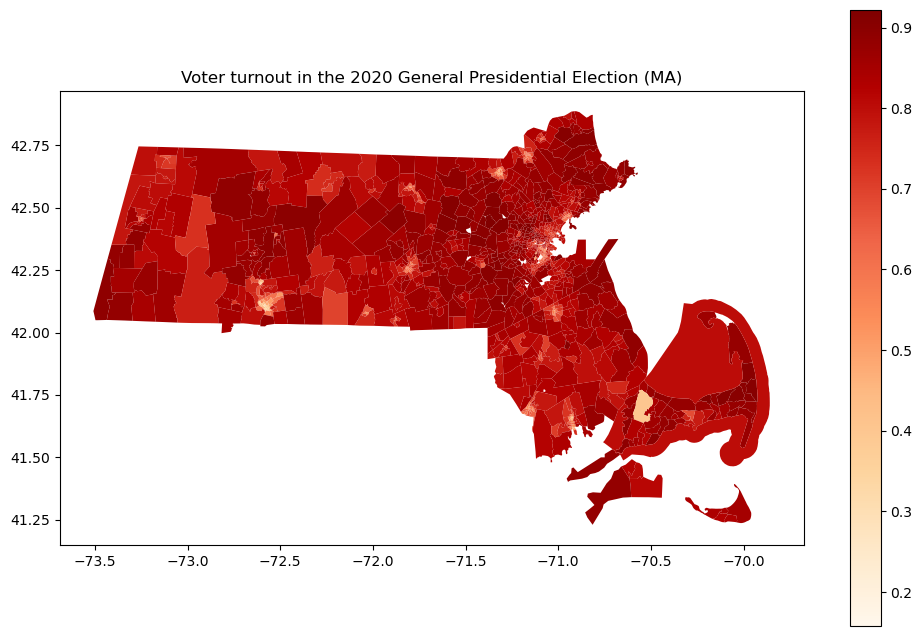

In [38]:
fig,ax = plt.subplots(figsize=(12,8))
tract_gdf.plot(column='g20201103_pct_voted_all', cmap='OrRd', legend=True,ax=ax)
plt.title('Voter turnout in the 2020 General Presidential Election (MA)')

<Axes: >

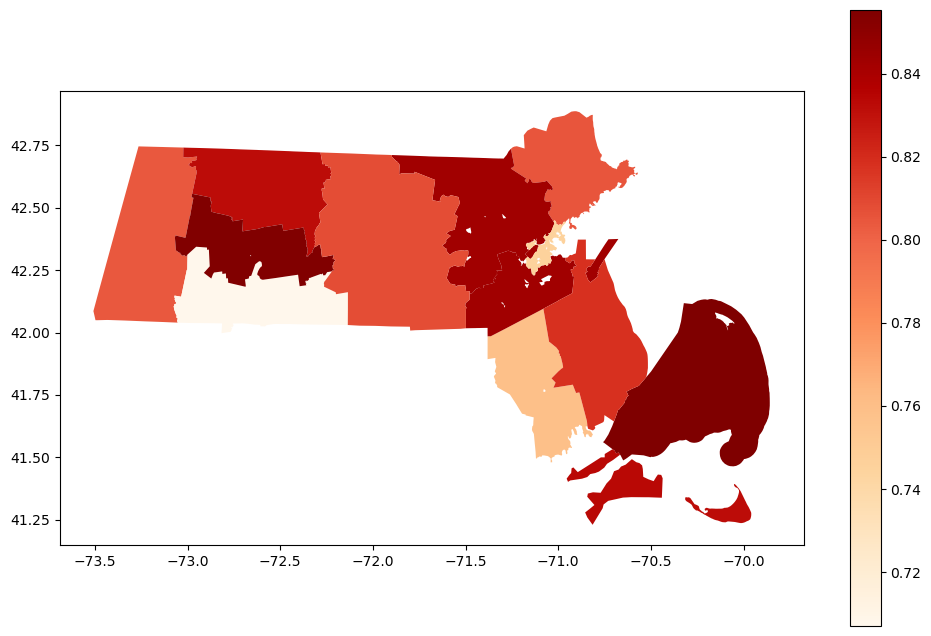

In [39]:
fig,ax = plt.subplots(figsize=(12,8))
county_gdf.plot(column='g20201103_pct_voted_all', cmap='OrRd', legend=True, ax=ax)

Text(0.5, 1.0, 'Voter registration in the 2020 General Presidential Election (MA)')

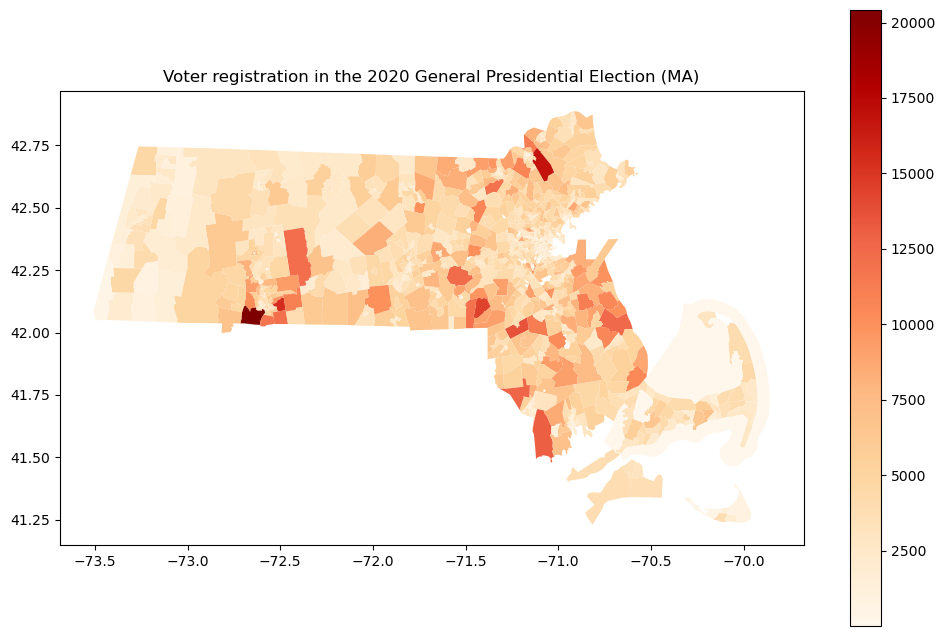

In [40]:
fig,ax = plt.subplots(figsize=(12,8))
tract_gdf.plot(column='total_reg', cmap='OrRd', legend=True,ax=ax)
plt.title('Voter registration in the 2020 General Presidential Election (MA)')

<Axes: >

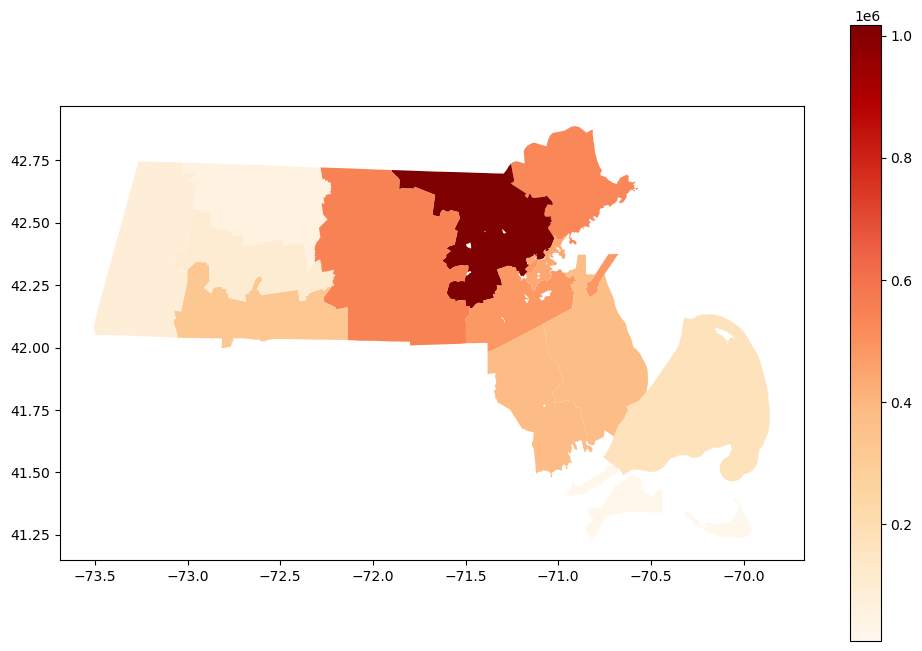

In [41]:
fig,ax = plt.subplots(figsize=(12,8))
county_gdf.plot(column='total_reg', cmap='OrRd', legend=True, ax=ax)